In [222]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import shap

### Correlation vs SHAP 

I want to test and see how different the features are ranked based on correlation and SHAP values. 

Pearson correlation is used to measure the linear relationship between two variables, while SHAP takes into account the model as a whole and how each feature interacts with one another. 

In [223]:
#load in data 

data = pd.read_csv('AmesHousing_clean.csv')

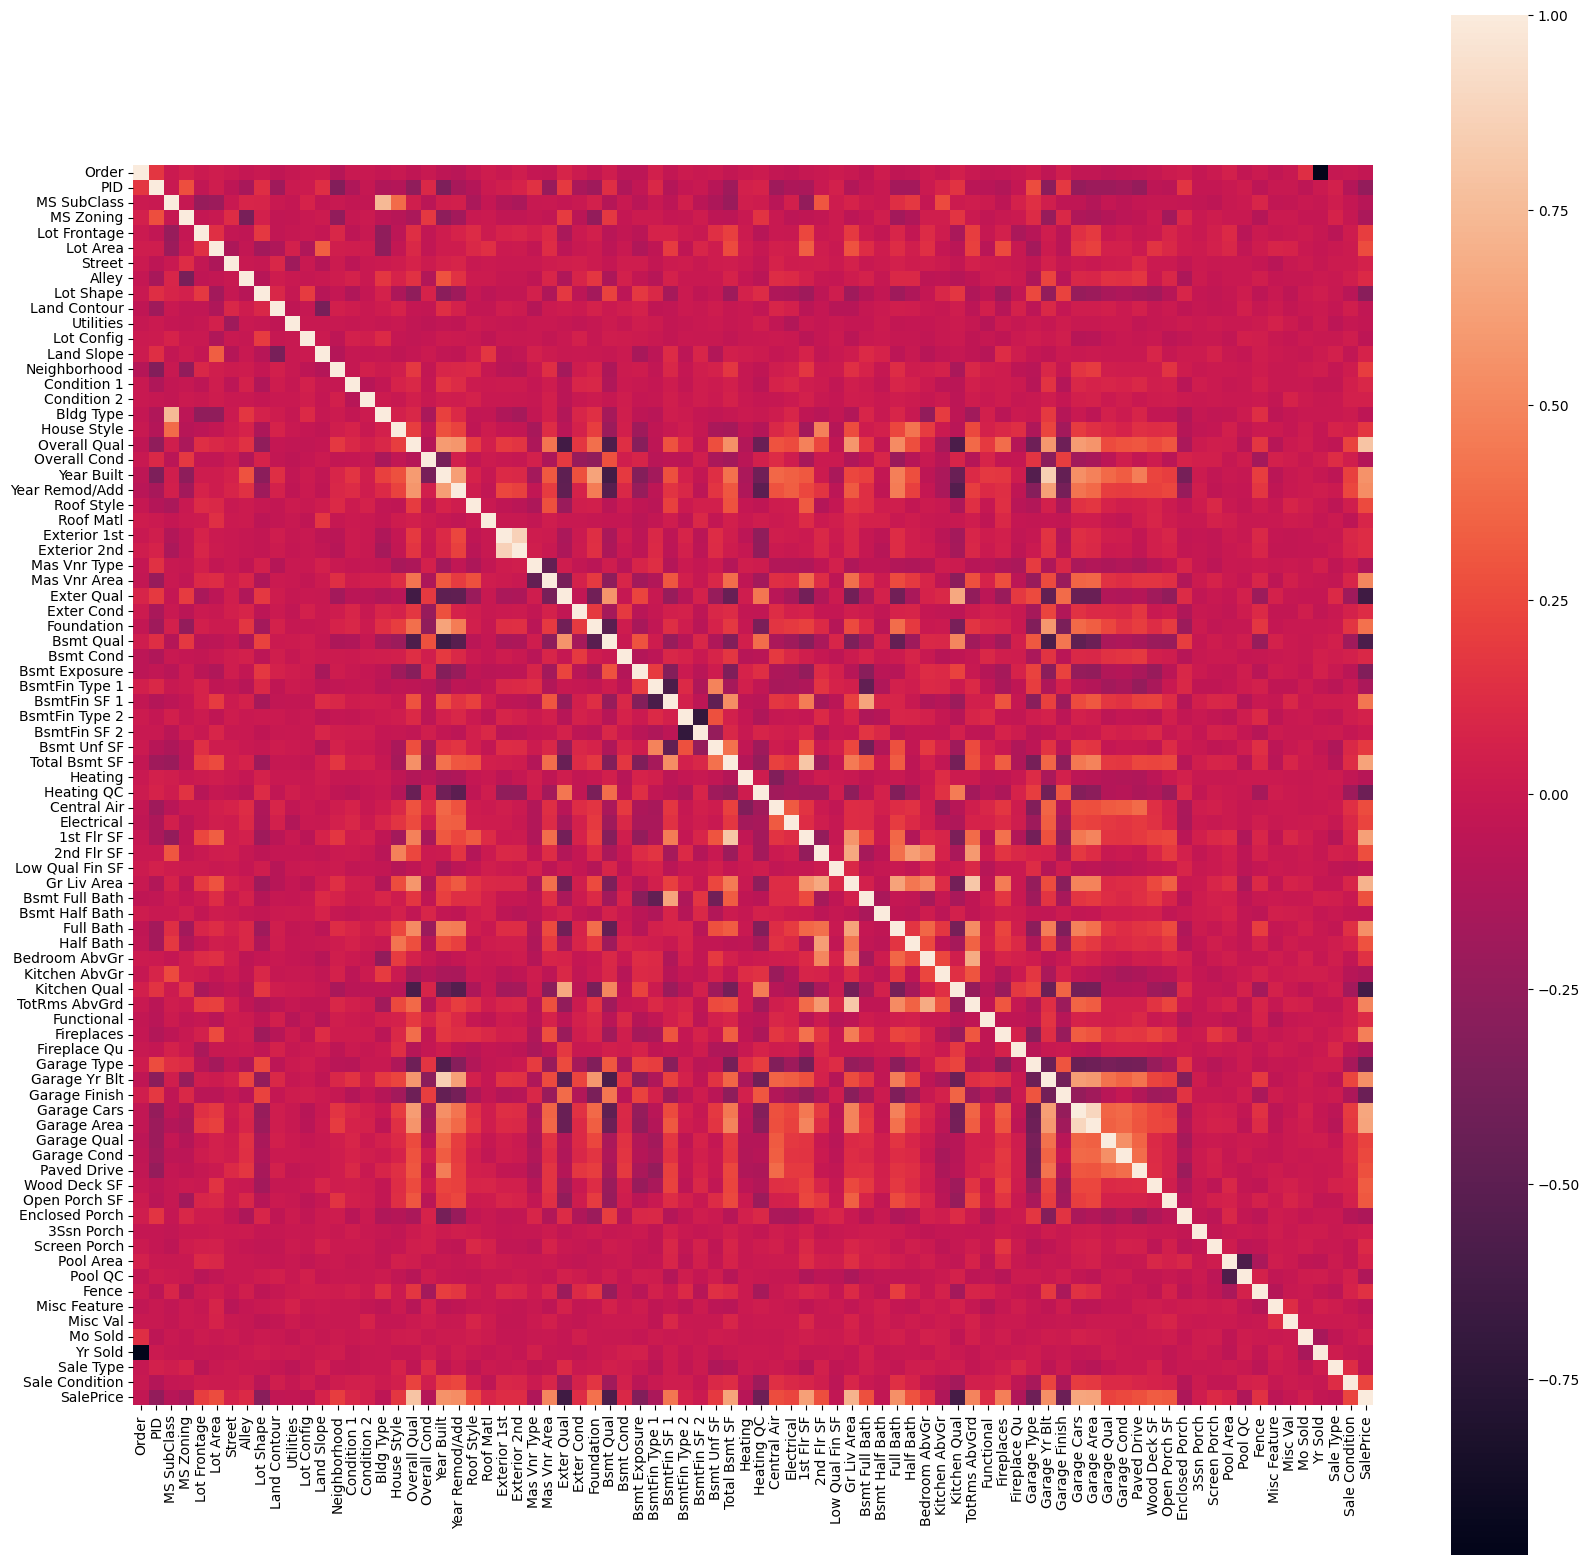

In [224]:
#calculate correlation matrix 

corr_matrix = data.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.show()


In [225]:
#Now lets just take the correlation of each feature to SalePrice

corrSalePrice = data.corrwith(data['SalePrice'])
corrSalePrice = np.abs(corrSalePrice)
corrSalePrice.sort_values(inplace=True)
#remove SalePrice, PID, and Order. SalePrice is target and the others are not related to the house price, they are just for house ID
corrSalePrice = corrSalePrice.drop(['Order', 'PID', 'SalePrice'], axis = 0)

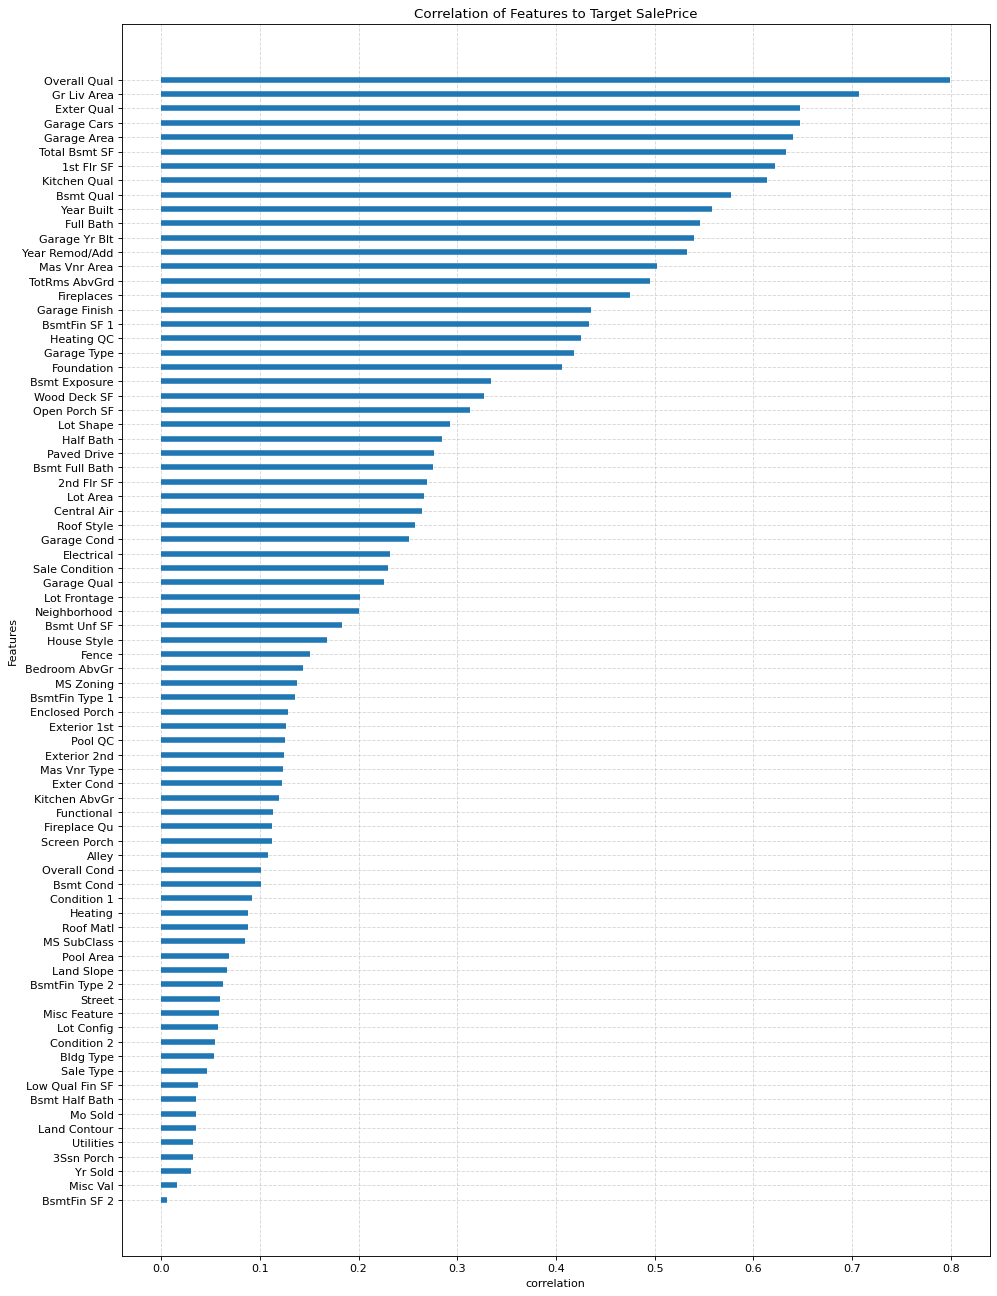

In [226]:
plt.figure(figsize=(14,20), dpi=80)

plt.hlines(y=corrSalePrice.index, xmin=0, xmax=corrSalePrice.values, linewidth =5)
plt.gca().set(xlabel = 'correlation', ylabel = "Features")
plt.title("Correlation of Features to Target SalePrice")
plt.grid(linestyle = '--', alpha= 0.5)

plt.show()

In [227]:
#list of top ten features based on correlation 
corrSalePrice.sort_values(inplace=True, ascending=False)
corrSalePrice[:10]
corrSalePrice = pd.DataFrame(corrSalePrice.values, corrSalePrice.index, columns = ['correlation_SalePrice'])

In [228]:
corrSalePrice['Rank'] = corrSalePrice['correlation_SalePrice'].rank(ascending=False)

In [229]:
X = data.iloc[:,2:-1]
y = data["SalePrice"]

In [230]:
#Now I want to calculate the SHAP values for the features. I will load in a model to do so
model = xgb.Booster(model_file='model_1.bin')

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [231]:
shap_df = pd.DataFrame(shap_values, columns = X.columns)
vals = np.abs(shap_df.values).mean(0)

shap_importance = pd.DataFrame(list(zip(X.columns, vals)), columns = ['feature', 'feature_importance'])
shap_importance = shap_importance.set_index('feature')

In [232]:
shap_importance.sort_values(by = 'feature_importance', ascending=False, inplace = True)

In [233]:
shap_importance['Rank'] = shap_importance['feature_importance'].rank(ascending=False)

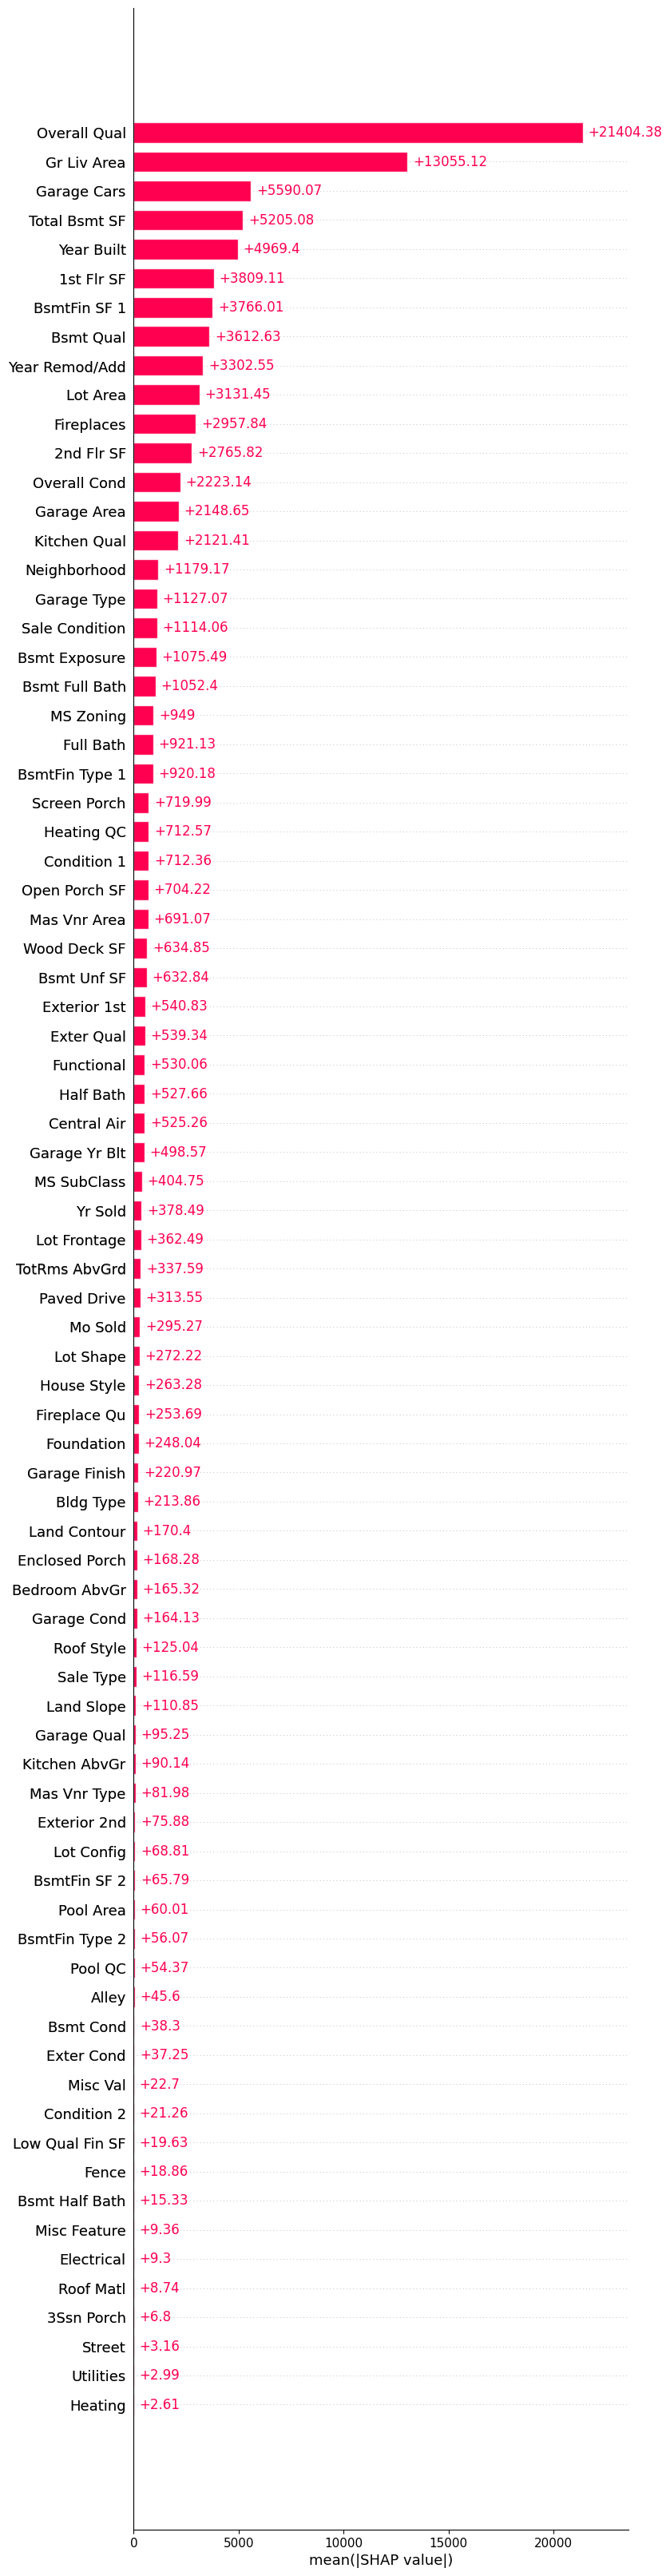

In [234]:
shap.plots.bar(explainer(X), max_display = 79)

In [235]:
feat_importance = shap_importance.merge(corrSalePrice, left_index=True, right_index=True, suffixes=('Shap', 'Corr'))
feat_importance['CorrRank_change'] = feat_importance['RankShap'] - feat_importance['RankCorr']

In [236]:
feat_import_weight = model.get_score(importance_type='weight')
feat_import_gain = model.get_score(importance_type='gain')

In [238]:
feat_import = pd.DataFrame(list(zip(X.columns, feat_import_weight.values(),feat_import_gain.values())), columns = ['feature', 'weight', 'gain'])
feat_import.set_index('feature', inplace = True)

In [239]:
feat_import['RankGain'] = feat_import['gain'].rank(ascending=False)
feat_import['RankWeight'] = feat_import['weight'].rank(ascending=False)

In [240]:
feat_importance = feat_importance.merge(feat_import, left_index=True, right_index=True)

In [241]:
feat_importance['GainRank_change'] = feat_importance['RankShap'] - feat_importance['RankGain']
feat_importance['WeightRank_change'] = feat_importance['RankShap'] - feat_importance['RankWeight']

In [244]:
feat_importance[['RankShap','RankCorr','CorrRank_change', 'RankGain','GainRank_change', 'RankWeight','WeightRank_change']][:10]

,RankShap,RankCorr,CorrRank_change,RankGain,GainRank_change,RankWeight,WeightRank_change
Overall Qual,1.0,1.0,0.0,2.0,-1.0,11.0,-10.0
Gr Liv Area,2.0,2.0,0.0,4.0,-2.0,2.0,0.0
Garage Cars,3.0,4.0,-1.0,1.0,2.0,51.5,-48.5
Total Bsmt SF,4.0,6.0,-2.0,6.0,-2.0,4.0,0.0
Year Built,5.0,10.0,-5.0,14.0,-9.0,6.5,-1.5
1st Flr SF,6.0,7.0,-1.0,9.0,-3.0,6.5,-0.5
BsmtFin SF 1,7.0,18.0,-11.0,18.0,-11.0,5.0,2.0
Bsmt Qual,8.0,9.0,-1.0,3.0,5.0,38.5,-30.5
Year Remod/Add,9.0,13.0,-4.0,19.0,-10.0,13.5,-4.5
Lot Area,10.0,30.0,-20.0,28.0,-18.0,1.0,9.0


In [256]:
feat_importance[feat_importance.index == 'Full Bath']

,feature_importance,RankShap,correlation_SalePrice,RankCorr,CorrRank_change,weight,gain,RankGain,RankWeight,GainRank_change,WeightRank_change,Avg_Rank
Full Bath,921.129456,22.0,0.545604,11.0,11.0,35.0,1.167960e+10,11.0,46.5,11.0,-24.5,22.833333
